<a href="https://colab.research.google.com/github/sertansenturk/20makam/blob/master/notebooks/03_model_experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

End-to-end multi-label classification using deep learning
=============================================================

Based on ISMIR 2021 supervised classification tutorial: 

- Notebook in Github: https://github.com/music-classification/tutorial/blob/main/book/part3_supervised/tutorial.ipynb
- Tutorial Book: https://music-classification.github.io/tutorial/part3_supervised/tutorial.html


## Install packages

Below we check the CUDA version installed on the colab instance.

In [65]:
!nvcc -V
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Wed Jun 22 20:50:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |   1085MiB / 16280MiB |      0%      Default |
|                               |            

In [66]:
# deep learning & mir
!pip install torch torchvision torchaudio
!pip uninstall -y torchtext
!pip install pytorch-lightning
!pip install mirdata scikit-learn
!pip install torchmetrics

# download data
!pip install gdown


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Set up ssh access

From https://colab.research.google.com/drive/1A5ocDslM9ZTo1pbt6klaV4Uo0LVjx3kF?usp=sharing#scrollTo=rlDieMPTq7Sz

Below commands are commented out so we don't generate the key unless needed. Uncomment and run them if you want to create a new key

!ssh-keygen -t rsa -b 4096d  
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts  
!cat /root/.ssh/id_rsa.pub 


Copy the key above and add it here: https://github.com/settings/keys

Then make sure the key works, and set up your user.

!ssh -T git@github.com  

!git config --global user.email "contact@sertansenturk.com"  
!git config --global user.name "Sertan Senturk"  

## Install the repo

**Important:** The repo is private; make sure you have ssh access to Github.

In [67]:
!git clone git@github.com:sertansenturk/utopia_challenge.git
%cd /content/utopia_challenge

Cloning into 'utopia_challenge'...
remote: Enumerating objects: 745, done.
remote: Counting objects: 100% (294/294), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 745 (delta 176), reused 204 (delta 109), pack-reused 451
Receiving objects: 100% (745/745), 82.84 MiB | 11.25 MiB/s, done.
Resolving deltas: 100% (378/378), done.
/content/utopia_challenge


In [ ]:
!pip install -r requirements.txt
!pip install .
!pwd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/utopia_challenge
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for multilabel-tagger: filename=multilabel_tagger-0.2.0-py3-none-any.whl size=7752 sha256=edf4b6fb852267ce38cae2f2bb703d6a0fbfce12766d5fef8f43b2eb0e33c4cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-vkygrdwp/wheels/dd/bb/f6/89359feae04f4aa2b21d96bdbbfb99512ed00bfb9f435f3017
Successfully built multilabel-tagger
  Attempting uninstall: multilabel-

We import the packages and we set the random_seed for our experiments. The random seed makes sure the experiment is reproducible on this environment.

We use mirdata to load the datasets, sklearn for data partitioning, torchaudio to load and transform audio files, and pytorch lightning on top of pytorch for machine learning. 

In [ ]:
import random

from typing import Dict, List, Tuple, Union
from pathlib import Path

import IPython
import mirdata
import numpy as np
import pandas as pd
import sklearn
import torch
import torchaudio
import pytorch_lightning as pl
import torchmetrics

import multilabel_tagger as mlt


In [ ]:
RANDOM_SEED = 42  # life, universe and everything
pl.utilities.seed.seed_everything(seed=RANDOM_SEED)

Global seed set to 42


42

In [ ]:
logger = mlt.logging_utils.get_jupyter_logger(name = __name__)
logger.info("init logger")

INFO:__main__:init logger


## Data processing

### Prepare annotations

We first need to preprocess the anntoations (e.g. binarize tag strengths, remove untagged recordings) and then split the data into train & test.

I call the correspondings steps in `multilabel_tagger` to prepare the annotations.

In [ ]:
!mlt --config tagger_config.yml process_annotations


INFO:multilabel_tagger.driver:Configuration:
process_annotations:
    input_path: ./data/inputs/musimotion_testset_annotations_cut.csv 
    processed_path: ./data/interim/process_annotations/processed_annotations.csv
    info_path: ./data/interim/process_annotations/processed_annotations-info.json
    process_strength_method: binarize
    uncommon_tag_discard_ratio: 0.04
split_train_test:
    train_split_path: ./data/interim/split_train_test/train/train_split.csv
    test_split_path: ./data/interim/split_train_test/test/test_split.csv
    train_split_info_path: ./data/interim/split_train_test/train/train_split-info.json
    test_split_info_path: ./data/interim/split_train_test/test/test_split-info.json
    test_size: 0.3
    random_state: 42

INFO:multilabel_tagger.driver:========= process_annotations ===========
INFO:multilabel_tagger.data.annotation:Reading annotations from ./data/inputs/musimotion_testset_annotations_cut.csv.
INFO:multilabel_tagger.data.annotation:Processing annotat

In [ ]:
!mlt --config tagger_config.yml split_train_test


INFO:multilabel_tagger.driver:Configuration:
process_annotations:
    input_path: ./data/inputs/musimotion_testset_annotations_cut.csv 
    processed_path: ./data/interim/process_annotations/processed_annotations.csv
    info_path: ./data/interim/process_annotations/processed_annotations-info.json
    process_strength_method: binarize
    uncommon_tag_discard_ratio: 0.04
split_train_test:
    train_split_path: ./data/interim/split_train_test/train/train_split.csv
    test_split_path: ./data/interim/split_train_test/test/test_split.csv
    train_split_info_path: ./data/interim/split_train_test/train/train_split-info.json
    test_split_info_path: ./data/interim/split_train_test/test/test_split-info.json
    test_size: 0.3
    random_state: 42

INFO:multilabel_tagger.driver:========= split_train_test ===========
INFO:multilabel_tagger.data.annotation:Reading annotations from ./data/interim/process_annotations/processed_annotations.csv.
INFO:multilabel_tagger.data.dataset_splitter:Splitti

In [ ]:
SPLIT_PATHS = {
    "train": Path("data/interim/split_train_test/train/train_split.csv"),
    "test": Path("data/interim/split_train_test/test/test_split.csv")
}

### Download audio data from GDrive

The audio recordings are stored in https://drive.google.com/uc?id=1AOZ8IwNo8nSbIRFr8rqzjnbQQ2bnxKNN as a tar.gz file. We download the dataset and uncompress to `./data/inputs/musimotion_youtube_subtestset`.


In [ ]:
!gdown https://drive.google.com/uc?id=1AOZ8IwNo8nSbIRFr8rqzjnbQQ2bnxKNN -O ./data/inputs/
!tar -zxf ./data/inputs/musimotion_testset.tar.gz -C ./data/inputs/
!ls ./data/inputs/musimotion_youtube_subtestset


Downloading...
From: https://drive.google.com/uc?id=1AOZ8IwNo8nSbIRFr8rqzjnbQQ2bnxKNN
To: /content/utopia_challenge/data/inputs/musimotion_testset.tar.gz
100% 5.49G/5.49G [00:57<00:00, 96.0MB/s]
04F4xlWSFh0.mp3  CAFbqlldb4E.mp3  _KhQT-LGb-4.mp3  s6BHQztjkuU.mp3
06Ot0DaN1hM.mp3  cao6WyF-61s.mp3  khrx-zrG460.mp3  S87jWwzvwd8.mp3
09BB1pci8_o.mp3  cb2w2m1JmCY.mp3  Ki5aS5LSrQM.mp3  SBHucOSjkQs.mp3
0fAQhSRLQnM.mp3  cBMAw21l4_k.mp3  kjCW38GFeRA.mp3  ScNgrQ1EXr0.mp3
0InCN5ssSeM.mp3  cCRq6NpIP8s.mp3  kJQP7kiw5Fk.mp3  sCQfTNOC5aE.mp3
0j64SZhdoa0.mp3  CDmWJbN8bDo.mp3  kK5AohCMX0U.mp3  SDTZ7iX4vTQ.mp3
0P2a6aLDkkM.mp3  CdVEwjGLEYk.mp3  KkhGkRahU6g.mp3  Sfg6-4mBs6Y.mp3
0t5gbhk4l7k.mp3  cG7cRDcPY3k.mp3  kkJC8p48g6g.mp3  SGWYbkXCcGU.mp3
0TNYMvrYrMM.mp3  CgMl5nm1hpg.mp3  kkx-7fsiWgg.mp3  sHVNaitVBlY.mp3
0tYBeF4bhNQ.mp3  C_HmbIPdz34.mp3  Kq6DUFqTo7M.mp3  SJsaWXt9GqM.mp3
0vo23H9J8o8.mp3  _CI-0E_jses.mp3  KT0jTZAiN-g.mp3  SKSuUOwOMTA.mp3
0ZiWKNzUD-0.mp3  CinJuVtdp3Y.mp3  kTjfl0yhyRk.mp3  SldKwr1R0Yk.mp3
1

In [ ]:
AUDIO_FILES = np.array(list(Path("./data/inputs/musimotion_youtube_subtestset/").glob("*.mp3")))

logger.info(f"{len(AUDIO_FILES)} audio files.")
display(AUDIO_FILES[:5])


INFO:__main__:663 audio files.


array([PosixPath('data/inputs/musimotion_youtube_subtestset/Dxkjj-W801A.mp3'),
       PosixPath('data/inputs/musimotion_youtube_subtestset/q_scNPUGcDs.mp3'),
       PosixPath('data/inputs/musimotion_youtube_subtestset/Ixrje2rXLMA.mp3'),
       PosixPath('data/inputs/musimotion_youtube_subtestset/haas3N9vxsM.mp3'),
       PosixPath('data/inputs/musimotion_youtube_subtestset/Epgo8ixX6Wo.mp3')],
      dtype=object)


In order to use this dataset with pytorch, we extend the Dataset object to load the audio and annotations in our dataset, according to these [instructions](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

We basically need to write three methods:

*   __init__
*   __len__
*   __getitem__ to return each pair of audio array and class label


This is how a prototype of this class could look like:

```
class UtopiaDataset(torch.utils.data.Dataset):
    def __init__(self):
      self.track_ids = dataset.track_ids
    def __getitem__(self, index):
      # load data
      audio = load_audio(self.track_ids[index])
      label = self.track_ids[index].label
      # split audio in a fixed size array
      audio = audio[:seq_duration] 
      return audio,label
    def __len__(self):
      return len(self.tracks_ids)

```

Let's implement the class:


In [ ]:
class UtopiaDatasetSplit(torch.utils.data.Dataset):
    FRAME_OFFSET = 0

    def __init__(
        self,
        split_annotation_path: Path,
        audio_filepaths: List[Path],
        split_type: str = "train",
        seq_duration: float = 30,  # seconds
        random_start: bool = True,
        resample: int = 8000
    ):
        self._prepare_split_data(
            audio_filepaths,
            split_annotation_path
        )
        self.split_type = split_type # TODO: enum
        self.seq_duration = seq_duration
        self.random_start = random_start
        self.resample = resample

    def _prepare_split_data(
        self,
        audio_filepaths: List[str],
        split_annotation_path: str
    ) -> Tuple[List[Dict], Dict[str, int]]:
        annotations = self._read_annotation_data(split_annotation_path)
        self.label_map = self._map_labels(annotations)

        self.data = []
        for fp in audio_filepaths:
          filename = fp.name
          if filename in annotations.index:
            audio_label_series = annotations.loc[filename]
            labels = audio_label_series[audio_label_series==True].index.to_list()
            label_idx = [self.label_map[lbl] for lbl in labels]
            is_pop = int("Pop" in labels)
            is_rock = int("Rock" in labels)

            self.data.append({
                "audio_path": fp,
                "labels": labels,
                "label_idx": label_idx,
                "is_pop": is_pop, # temporary to make sure we have a result
                "is_rock": is_rock # temporary to make sure we have a result
            })

    @staticmethod
    def _read_annotation_data(path) -> pd.DataFrame:
        split = mlt.data.Annotation(path)
        split.extract()
        logger.info(f"{len(split.data)} recordings in the split.")

        return split.data

    @staticmethod
    def _map_labels(annotations) -> Dict:
        """maps tags (labels) to integers, e.g. `Pop -> 12`
        """
        # TODO: brittle implementation; works because both splits consist 
        # of all tags. We should create a enum singleton
        unique_labels = sorted(annotations.columns.unique())
        return {label: i for i, label in enumerate(unique_labels)}

    def __getitem__(self, index):
        audio_path = self.data[index]["audio_path"]
        label_idx = self.data[index]["label_idx"]
        metadata_dict = self._get_audio_metadata(audio_path)

        # cut audio to the first `seq_duration` seconds to reduce training time
        # (so I could finish the challenge)
        num_frames = min([
            int(np.floor(self.seq_duration * metadata_dict["sample_rate"])),
            metadata_dict["num_samples"]
        ])

        audio_signal, sample_rate = torchaudio.load(
            filepath=audio_path,
            frame_offset=self.FRAME_OFFSET,
            num_frames=num_frames
        )

        # convert to mono
        audio_signal = audio_signal.mean(dim=0).reshape((1, -1))
        audio_signal = torchaudio.transforms.Resample(
            sample_rate,
            self.resample
        )(audio_signal)

        if audio_signal.shape[-1] != 240000:
          print(index, audio_signal.shape)
          print(metadata_dict)

        # return resampled_signal, label_idx
        return audio_signal, self.data[index]["is_pop"]

    @staticmethod
    def _get_audio_metadata(audio_path):
        str_path = str(audio_path)  # torchaudio doesn't accept Path objects
        metadata = torchaudio.info(str_path)

        return {
            "sample_rate": metadata.sample_rate,
            "num_channels": metadata.num_channels,
            "num_samples": metadata.num_frames,
            "duration": metadata.num_frames / metadata.sample_rate,
        }        

    def __len__(self):
        return len(self.data)


We initialize the dataset objects for train, and test. We define the corresponding pytorch objects for data loading, defining the batch_size (paralellization on the GPU) and the num_workers ( data loading paralellization on CPU/memory).

In [ ]:
split_dataset_loader_dict = {}
for split_str in ["train", "test"]:
    dataset = UtopiaDatasetSplit(
        split_annotation_path=SPLIT_PATHS[split_str],
        audio_filepaths=audio_files,
        split_type=split_str
    )
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=32,
        num_workers=2,
        pin_memory=True
    )
    split_dataset_loader_dict[split_str] = {
        "dataset": dataset,
        "loader": loader
    }


INFO:multilabel_tagger.data.annotation:Reading annotations from data/interim/split_train_test/train/train_split.csv.
INFO:__main__:458 recordings in the split.
INFO:multilabel_tagger.data.annotation:Reading annotations from data/interim/split_train_test/test/test_split.csv.
INFO:__main__:194 recordings in the split.


In [ ]:
display(split_dataset_loader_dict)
display(split_dataset_loader_dict['test']['dataset'][10])
display(split_dataset_loader_dict['test']['dataset'][10][0].shape)

{'test': {'dataset': <__main__.UtopiaDatasetSplit at 0x7f12c822c490>,
  'loader': <torch.utils.data.dataloader.DataLoader at 0x7f1352c85750>},
 'train': {'dataset': <__main__.UtopiaDatasetSplit at 0x7f12c824b310>,
  'loader': <torch.utils.data.dataloader.DataLoader at 0x7f12c824c4d0>}}

(tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0205,  0.0208,  0.0372]]), 0)

torch.Size([1, 240000])

In [ ]:
import librosa
import matplotlib.pyplot as plt
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:508: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


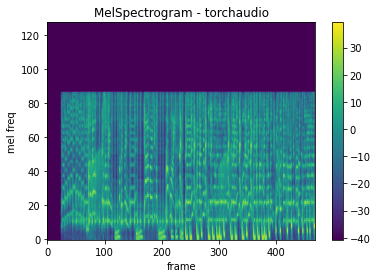

In [ ]:
melspec = torchaudio.transforms.MelSpectrogram(
    sample_rate=8000,
    n_fft=1024,
    f_min=20,
    f_max=11025,
    n_mels=128
)(split_dataset_loader_dict['test']['dataset'][1][0])

plot_spectrogram(
    melspec[0], title="MelSpectrogram - torchaudio", ylabel='mel freq')

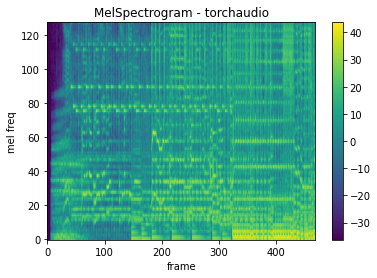

In [ ]:
melspec = torchaudio.transforms.MelSpectrogram(
    sample_rate=8000,
    n_fft=1024,
    f_min=20,
    f_max=4000,
    n_mels=128,
)(split_dataset_loader_dict['test']['dataset'][41][0])

plot_spectrogram(
    melspec[0], title="MelSpectrogram - torchaudio", ylabel='mel freq')


**Which batch size/learning rate?**

Theory suggests that when multiplying the batch size by k, one should multiply the learning rate by sqrt(k) to keep the variance in the gradient expectation constant. See page 5 at A. Krizhevsky. One weird trick for parallelizing convolutional neural networks: https://arxiv.org/abs/1404.5997

However, recent experiments with large mini-batches suggest for a simpler linear scaling rule, i.e multiply your learning rate by k when using mini-batch size of kN. See P.Goyal et al.: Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour https://arxiv.org/abs/1706.02677

## Training a pytorch lightning classifier

We extend the pytorch lightning module according to the [documentation](https://pytorch-lightning.readthedocs.io/en/stable/new-project.html). This may contain a definition of the layers in the neural network and how the data flows (how the layers are connected). You may overwrite other functions from `pl.LightningModule`, as described [here](https://pytorch-lightning.readthedocs.io/en/latest/lightning_module.html). The most important are `training_step` and `configure_optimizers`, in which we define the training loss and the optimizers.

W = W - lr * Delta(W) -> Stochastic gradient descent
W = [w1 ... w10] [l1...l10] 

```
>>> class LitModel(pl.LightningModule):
...
...     def __init__(self):
...         super().__init__()
...         self.l1 = torch.nn.Linear(28 * 28, 10)
...
...     def forward(self, x):
...         return torch.relu(self.l1(x.view(x.size(0), -1)))
...
...     def training_step(self, batch, batch_idx):
...         x, y = batch
...         y_hat = self.forward(x)
...         loss = F.cross_entropy(y_hat, y)
...         return loss
...
...     def configure_optimizers(self):
...         return torch.optim.Adam(self.parameters(), lr=0.02)
```



We first build a Conv2D module which stacks several layers: 2D convolution, batch normalization, relu, maxpool, dropout

In [ ]:
class Conv_2d(torch.nn.Module):
    def __init__(self, input_channels, output_channels, shape=3, pooling=2, dropout=0.1):
        super(Conv_2d, self).__init__()
        self.conv = torch.nn.Conv2d(input_channels, output_channels, shape, padding=shape//2)
        self.bn = torch.nn.BatchNorm2d(output_channels)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(pooling)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, wav):
        out = self.conv(wav)
        out = self.bn(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        return out

We predict the 10 classes of the Mridangam stroke dataset with a CNN using as input the MFCCs computed from audio files.

In [ ]:
class CNN(pl.LightningModule):
    '''
    Simple CNN classification architecture: https://music-classification.github.io/tutorial/part3_supervised/tutorial.html
    '''
    def __init__(
        self,
        num_channels=16, 
        sample_rate=8000, 
        n_fft=1024, 
        f_min=0.0, 
        f_max=4000, 
        num_mels=128, 
        num_classes=2 # TODO: change to include all labels
    ):
        super().__init__()

        self.celoss = torch.nn.CrossEntropyLoss()

        # mel spectrogram
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            f_min=f_min,
            f_max=f_max,
            n_mels=num_mels
        )
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()
        self.input_bn = torch.nn.BatchNorm2d(1)

        # convolutional layers
        self.layer1 = Conv_2d(1, num_channels, pooling=(2, 3))
        self.layer2 = Conv_2d(num_channels, num_channels, pooling=(2, 3))
        self.layer3 = Conv_2d(num_channels, num_channels * 2, pooling=(2, 4))
        self.layer4 = Conv_2d(num_channels * 2, num_channels * 2, pooling=(3, 3))
        self.layer5 = Conv_2d(num_channels * 2, num_channels * 4, pooling=(3, 4))

        # dense layers
        self.dense1 = torch.nn.Linear(num_channels * 4, num_channels * 4)
        self.dense_bn = torch.nn.BatchNorm1d(num_channels * 4)
        self.dense2 = torch.nn.Linear(num_channels * 4, num_classes)
        self.dropout = torch.nn.Dropout(0.5)
        self.relu = torch.nn.ReLU()

        #### metrics
        self.train_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()
        self.test_cm = torchmetrics.classification.ConfusionMatrix(
            num_classes=num_classes
        )

    def forward(self, waveform):
        # input Preprocessing
        out = self.melspec(waveform)
        
        out = self.amplitude_to_db(out)

        # input batch normalization
        #out = out.unsqueeze(1)
        out = self.input_bn(out)
       
        # convolutional layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        
        # reshape. (batch_size, num_channels, 1, 1) -> (batch_size, num_channels)
        out = out.reshape(len(out), -1)

        # dense layers
        out = self.dense1(out)
        out = self.dense_bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.dense2(out)

        return out

    def training_step(self, batch, batch_idx):
        waveform, label = batch
        logits = self.forward(waveform)
        loss = self.celoss(logits, label)
        self.log('train_loss', loss)
        _, pred = torch.max(logits, 1)
        self.train_acc(pred, label)
        self.log('train_acc', self.train_acc, on_step=True, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        waveform, label = batch
        b, c, t = waveform.size()
        logits = self.forward(waveform)
        loss = self.celoss(logits, label)
        self.log('test_loss', loss)
        _, pred = torch.max(logits, 1)
        self.test_acc(pred, label)
        self.log('test_acc', self.test_acc, on_step=True, on_epoch=True)
        self.test_cm(pred, label)

    def training_epoch_end(self, outputs):
        # log epoch metric
        self.log('train_acc', self.train_acc.compute(), prog_bar=True)

    def test_epoch_end(self, outputs):
        self.log('test_acc', self.test_acc.compute(), prog_bar=True)

    def get_progress_bar_dict(self):
        # don't show the version number
        items = super().get_progress_bar_dict()
        items.pop("v_num", None)
        return items

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3,weight_decay=0.0001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # reduce the learning after 10 epochs by a factor of 10
        return [optimizer], [scheduler]


We train the model defined above.

In [ ]:
#### Initialize the model
model = CNN()

#### Initialize a trainer
trainer = pl.Trainer(gpus=1, max_epochs=10, progress_bar_refresh_rate=10)
# trainer = pl.Trainer(max_epochs=3, progress_bar_refresh_rate=10)

#### Train the model
trainer.fit(
    model,
    split_dataset_loader_dict['train']['loader'],
    split_dataset_loader_dict['test']['loader']
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:131: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")

Training: 0it [00:00, ?it/s]

mel: torch.Size([4, 1, 128, 469])
input batch norm: torch.Size([4, 1, 128, 469])
layer1: torch.Size([4, 16, 64, 234])
layer2: torch.Size([4, 16, 32, 117])
layer3: torch.Size([4, 32, 16, 58])
layer4: torch.Size([4, 32, 5, 58])
layer5: torch.Size([4, 64, 1, 58])
pre-dense reshape: torch.Size([4, 3712])

Once the model is trained we can use it to process data, save it, get the metrics on the test set. 

In [ ]:
# Put the model in production
model.eval()

# Compute metrics on the test set
trainer.test(dataloaders=split_dataset_loader_dict['test']['loader'])

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1447: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:155: LightningDeprecationWarning: The `LightningModule.get_progress_bar_dict` method was deprecated in v1.5 and will be removed in v1.7. Please use the `ProgressBarBase.get_metrics` instead.
  "The `LightningModule.get_progress_bar_dict` method was deprecated in v1.5 and will be removed in v1.7."
Restoring states from the checkpoint path at /content/utopia_challenge/lightning_logs/version_1/checkpoints/epoch=9-step=150.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Lo

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7628865838050842
     test_acc_epoch         0.7628865838050842
        test_loss            0.507173478603363
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.7628865838050842,
  'test_acc_epoch': 0.7628865838050842,
  'test_loss': 0.507173478603363}]

In [ ]:
# Put the model in production
model.eval()

# Compute metrics on the test set
trainer.test(dataloaders=split_dataset_loader_dict['test']['loader'])

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1447: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:155: LightningDeprecationWarning: The `LightningModule.get_progress_bar_dict` method was deprecated in v1.5 and will be removed in v1.7. Please use the `ProgressBarBase.get_metrics` instead.
  "The `LightningModule.get_progress_bar_dict` method was deprecated in v1.5 and will be removed in v1.7."
Restoring states from the checkpoint path at /content/utopia_challenge/lightning_logs/version_0/checkpoints/epoch=9-step=150.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Lo

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7628865838050842
     test_acc_epoch         0.7628865838050842
        test_loss           0.46033230423927307
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.7628865838050842,
  'test_acc_epoch': 0.7628865838050842,
  'test_loss': 0.46033230423927307}]

NameError: ignored

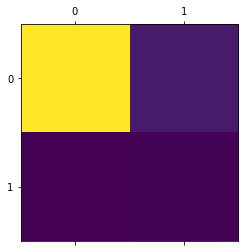

In [ ]:
#### Compute confusion matrix on the test set
confusion_matrix = model.test_cm.compute().cpu().numpy()
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.matshow(confusion_matrix)
ax.set_xticks(range(len(train_dataset.labels)))
ax.set_yticks(range(len(train_dataset.labels)))
ax.set_xticklabels(train_dataset.labels)
ax.set_yticklabels(train_dataset.labels)
plt.show()